# Predicting of arrival delay of a flight

Assignment problems and solutions.

### Importing all we will need

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

### Loading train data

In [2]:
flights_data = pd.read_table('./data/flights.csv', sep=',')
flights_data = flights_data.reindex(np.random.permutation(flights_data.index))

print(flights_data.shape)
flights_data.head()

(24193, 14)


,FL_DATE,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
8144,2018-04-11,BWI,"Baltimore, MD",12478,"New York, NY",1700,1708.0,8.0,1828,1911.0,43.0,88.0,123.0,184.0
13358,2018-04-17,BOS,"Boston, MA",12953,"New York, NY",1300,1329.0,29.0,1428,1438.0,10.0,88.0,69.0,184.0
8047,2018-04-10,PBI,"West Palm Beach/Palm Beach, FL",12953,"New York, NY",1158,1231.0,33.0,1455,1458.0,3.0,177.0,147.0,1035.0
9348,2018-04-12,SDF,"Louisville, KY",12953,"New York, NY",1529,1541.0,12.0,1740,1746.0,6.0,131.0,125.0,659.0
2049,2018-04-03,DCA,"Washington, DC",12953,"New York, NY",600,553.0,-7.0,719,656.0,-23.0,79.0,63.0,214.0


In [3]:
flights_data.describe()

,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
count,24193.000000,24193.000000,24193.000000,24193.000000,24193.000000,24193.000000,24193.000000,24193.000000,24193.000000,24193.000000
mean,12747.944819,1297.970405,1306.464019,15.961890,1470.617906,1466.216716,8.430827,159.705948,152.170339,933.514033
std,235.278286,480.470027,498.578465,53.782423,520.283262,538.381581,57.276402,76.843112,75.426896,706.125616
min,12478.000000,30.000000,1.000000,-49.000000,2.000000,1.000000,-65.000000,50.000000,39.000000,94.000000
25%,12478.000000,900.000000,901.000000,-5.000000,1045.000000,1040.000000,-19.000000,102.000000,98.000000,419.000000
50%,12953.000000,1252.000000,1302.000000,-2.000000,1514.000000,1513.000000,-8.000000,136.000000,130.000000,740.000000
75%,12953.000000,1700.000000,1717.000000,12.000000,1905.000000,1914.000000,12.000000,185.000000,180.000000,1096.000000
max,12953.000000,2359.000000,2400.000000,1659.000000,2359.000000,2400.000000,1685.000000,585.000000,609.000000,4983.000000


### Understanding data

1. All given times are actual strings converted to numbers.
2. All counts are the same suggesting that there are no missing values.
3. Means of times all make sense except for minutes - they are wrong (biased), since there are no mins after 60 - but not a big deal - looks like we would not need them. The rest:<br>
   Dep time is about 1 o'clock, so there is no imbalance.<br>
   CRS dep time is 10 minutes to actual - makes sense.<br>
   CRS arr time is around 1.5 hours after dep time - makes sense.<br>
   Factual arr time is a few minutes earlier than sheduled - that's always the case based on my experience.<br>
   Time intervals and distance all as well seem to be fine.<br>
4. Std dev and percentiles all make sense as well.
5. Mins and maxes have negative numbers suggesting there are many flights arriving ahead of shedule.<br>
   Delay and elapsed time are apparently in minutes. Delays are with a few max outliers of 30 hours delay.
   

Let's visualize hists on dep time, elapsed time and distances to confirm our understanding.

In [4]:
flights_data.hist('DEP_TIME', bins = 20); None

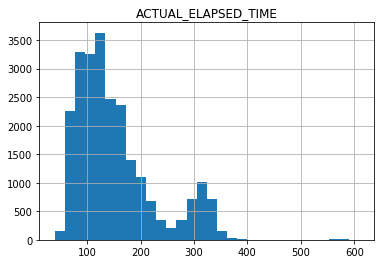

In [5]:
flights_data.hist('ACTUAL_ELAPSED_TIME', bins = 30); None

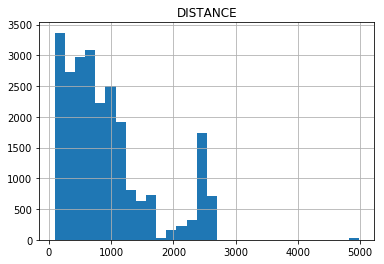

In [6]:
flights_data.hist('DISTANCE', bins = 30); None

Everything is as expected with histograms.

## Problem #1

#### a) What is the average duration of all the flights that landed in NY in April?

In [7]:
# first, let's filter out NY April flights
to_NY_in_april = (flights_data['FL_DATE'] >= '2018-04-01') &\
                 (flights_data['FL_DATE'] < '2018-05-01') &\
                 (flights_data['DEST_CITY_NAME'] == 'New York, NY')

filtered_data_size = flights_data[to_NY_in_april].shape[0]
print(f"Size of the data filtered by NY & April: {filtered_data_size} records.")
print(f"Size of the original dataset: {flights_data.shape[0]} records.")

Size of the data filtered by NY & April: 24193 records.
Size of the original dataset: 24193 records.


The same number of records after filtering - looks like the question is about the whole dataset.

In [8]:
avg_dur = flights_data['ACTUAL_ELAPSED_TIME'].mean()
print(f"So, the average duration of the flights is just {avg_dur:.1f}")

So, the average duration of the flights is just 152.2


#### b) For every minute in April, compute the average duration of the flights flying at that minute. Compute the average of these averages. Can you explain the difference with a)?

In [9]:
avg_dur_by_mins = flights_data.groupby('ARR_TIME').mean()['ACTUAL_ELAPSED_TIME'].mean()
print(f"Avergae duration of hte flights grouped by minutes: {avg_dur_by_mins:.1f}")

Avergae duration of hte flights grouped by minutes: 168.8


Of course the two numbers differ. This is due to the different weight (mass function, probability) applied to the values. In **a)** the weights of durations are all equal to 1. In **b)** durations are wieghted over minutes first.

To better illustrate what I mean imagine that there are 101 flights in total. A hundred of them took place at 14:00 and lasted 1 minute each; the last one was at 22:00 and lasted 10 minutes.

In average, duration is around 1 minute. But after grouping, the weight of that only flight increased 100 times. And average duration got 5.5 minutes.

Now, back to our case. Let's plot durations per minutes and see what caused such a discrepency.

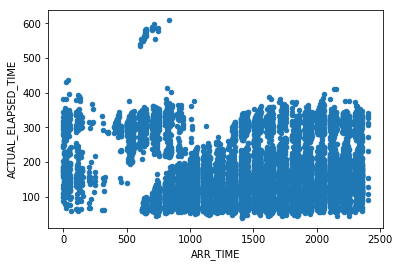

In [10]:
flights_data.plot.scatter('ARR_TIME', 'ACTUAL_ELAPSED_TIME'); None

In fact. We see that a lot of flights arrived at the daytime. They create the mass center. Night arrivals contribute just a little.

When after squashing by minutes, night flights contribute much more, having their mass at longer duration (around 300).

That is why we see the increase in duration after aggregating it by minutes. Below is just another visualization with the mass shifted towards longer duration.

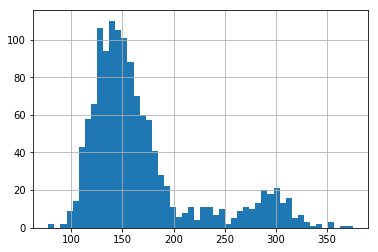

In [11]:
flights_data.groupby('ARR_TIME').mean()['ACTUAL_ELAPSED_TIME'].hist(bins = 50); None


## Problem #2

Build a model to predict the arrival delay of a flight:<br>
- beforehand
- after the departure

Explain the results.

### Developing a feature set

Ideally, we'd like to have features that are strongly correlated with the target.<br>
We'd also like to have features that aren't so strongly correlated with each other, so that they add independent information.

First, let's see which features correlate.<br>

In [3]:
flights_data.corr()

,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
DEST_AIRPORT_ID,1.000000,-0.071416,-0.045427,0.024656,0.110631,0.094954,0.039094,-0.379241,-0.374309,-0.369266
CRS_DEP_TIME,-0.071416,1.000000,0.938314,0.094443,0.475884,0.437725,0.074419,0.123321,0.114785,0.114102
DEP_TIME,-0.045427,0.938314,1.000000,0.175153,0.506025,0.475426,0.155368,0.086015,0.080685,0.075889
DEP_DELAY,0.024656,0.094443,0.175153,1.000000,0.096090,0.091036,0.958692,-0.027413,-0.013051,-0.029501
CRS_ARR_TIME,0.110631,0.475884,0.506025,0.096090,1.000000,0.846119,0.077176,-0.005309,-0.015316,-0.025532
ARR_TIME,0.094954,0.437725,0.475426,0.091036,0.846119,1.000000,0.082172,-0.021908,-0.024843,-0.041497
ARR_DELAY,0.039094,0.074419,0.155368,0.958692,0.077176,0.082172,1.000000,-0.080541,-0.006620,-0.078256
CRS_ELAPSED_TIME,-0.379241,0.123321,0.086015,-0.027413,-0.005309,-0.021908,-0.080541,1.000000,0.977259,0.995235
ACTUAL_ELAPSED_TIME,-0.374309,0.114785,0.080685,-0.013051,-0.015316,-0.024843,-0.006620,0.977259,1.000000,0.975623
DISTANCE,-0.369266,0.114102,0.075889,-0.029501,-0.025532,-0.041497,-0.078256,0.995235,0.975623,1.000000


As expected - after the departure there is a strong correlation with departure delay. But before departure - no features correlate with arr delay, just noise. But, do not be sad, that is only because we did not yet think.

Back two days ago when reading the problem in a messager, my first thought was dep airports were to blame for the arrival delays. Either their location is in bad whether conditions (in April or ever), or they are overloaded with traffic and hence crammed and jammed, or the management is bad taking no actions towards improvements.

Let's:
- use categorical features (ORIGIN and ORIGIN_CITY_NAME) - so far we only used numerical
- bin departure time - I do believe there is some correlation there too

In [3]:
# Define the input feature
features = flights_data[['ORIGIN']]

# Configure a categorical feature column for ORIGIN
origins = flights_data['ORIGIN'].unique()
feature_columns = [tf.feature_column.categorical_column_with_vocabulary_list('ORIGIN', origins)]

# Define the label
targets = flights_data['ARR_DELAY']

In [4]:
origins

array(['BWI', 'BOS', 'PBI', 'SDF', 'DCA', 'CLT', 'BHM', 'ORD', 'XNA',
       'PHL', 'ORF', 'MIA', 'TPA', 'DTW', 'ATL', 'RIC', 'IAH', 'CAE',
       'SFO', 'ROC', 'LAS', 'LAX', 'JAX', 'SLC', 'IND', 'PIT', 'DEN',
       'CMH', 'PWM', 'BNA', 'BUF', 'STL', 'BGR', 'IAD', 'CHS', 'CVG',
       'MSP', 'MCO', 'AGS', 'SMF', 'GSO', 'RDU', 'SAV', 'SEA', 'MDW',
       'PHX', 'FLL', 'DFW', 'BTV', 'SYR', 'RSW', 'MKE', 'ILM', 'CHO',
       'MSY', 'PDX', 'SAT', 'CLE', 'MCI', 'AUS', 'OAK', 'DAL', 'HOU',
       'SRQ', 'GRR', 'MHT', 'RNO', 'SJU', 'MYR', 'MEM', 'MSN', 'SAN',
       'BQN', 'OMA', 'DAB', 'LGB', 'HNL', 'PSP', 'DAY', 'BUR', 'GSP',
       'DSM', 'ABQ', 'EGE', 'LEX', 'SJC', 'TYS', 'ROA', 'CAK', 'STT',
       'PSE'], dtype=object)